This code implements the DBME method proposed and analyzed in the paper ``DEEP BACKWARD AND GALERKIN METHODS FOR LEARNING FINITE
STATE MASTER EQUATIONS'' by Asaf Cohen, Mathieu Laurière and Ethan Zell.

The example solved here corresponds to Example 7.1 in the paper.

In [26]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import math, pandas, sklearn, keras, random, copy, time
import matplotlib.pyplot as plt
tf.random.set_seed(703)
np.random.seed(703)

In [27]:

# Global, static parameters
d=2

In [28]:

class DBDatasetGenerator:
  '''
  This class generates the dataset for the DGM.
  '''
  def __init__(self, d=2, horizon=.5):
    self.d = d
    self.horizon = horizon

  def uniformly_random_measure(self):
    '''
    Uses exponential random variables to generate a uniformly random probability vector.
    '''
    pre_normalized = np.random.exponential(1, size = (self.d,))
    return pre_normalized / sum(pre_normalized)

  def uniformly_random_measure_vec(self, samples):
    '''
    Vectorizes the prior function.
    '''
    data = np.zeros((samples, self.d))
    for k in range(samples):
      data[k,:] = self.uniformly_random_measure()
    return data

  def generate_dataset(self, samples=1000):
    '''
    Creates the dataset which, for the DBME, needs only x and eta data.
    '''
    x_data = np.random.choice([float(m) for m in range(self.d)],size=samples)
    eta_data = self.uniformly_random_measure_vec(samples = samples)
    self.x_data = x_data
    self.eta_data = eta_data
    return x_data, eta_data

  def oversample_eta_bijection(self, x):
    return (2.* x) - 0.5

  def oversampling(self, oversample_eta = True, oversample_T = True):
    '''
    Apply this function after generate_dataset to modify the domain of the sampled eta and T.
    Sampling outside the domain may improve performance along the domain's boundary.
    '''
    if oversample_eta:
      self.eta_data = self.oversample_eta_bijection(self.eta_data)
    return self.x_data, self.eta_data

  def data_to_tensors(self):
    self.x_data = tf.convert_to_tensor(self.x_data, dtype = 'float32')
    self.eta_data = tf.convert_to_tensor(self.eta_data, dtype = 'float32')
    return self.x_data, self.eta_data

In [29]:
class DBMEModel(tf.keras.Model):
  '''
  This class defines the neural network model.
  '''
  def __init__(self, architecture):
    super(DBMEModel, self).__init__()
    self.architecture = architecture # you can give a list specifying the number of nodes in each dense layer
    self.layer_list = []

    for i,number_of_nodes in enumerate(architecture):
      if i == 0:
        self.layer_list.append(tf.keras.layers.Dense(units=number_of_nodes, activation='sigmoid',
                                                              kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1.),
                                                              bias_initializer='zeros'))
      else:
        self.layer_list.append(tf.keras.layers.Dense(units=number_of_nodes, activation='sigmoid',
                                                              kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1.),
                                                              bias_initializer='zeros'))
    self.layer_list.append(tf.keras.layers.Dense(units=1, activation = 'elu'))

  def call(self, x, eta):
    x = tf.expand_dims(x, axis = -1)
    input = tf.concat([x, eta], 1)
    result = input
    for layer in self.layer_list:
      result = layer(result)
    return result

Recall from the paper that we are interested in approximately solving the master equation:

$$
\partial_t U(t,x,\eta) = H(x,\Delta_x U(t,\cdot,\eta))+ F(x,\eta) + \sum_{y,z\in [d]} D^\eta_{yz} U(t,x,\eta) \gamma^*_z(y,\Delta_y U(t,\cdot,\eta)) \eta_y,
$$

where in this example:

$$F(x,\eta) = \eta_x,$$

$$H(x,p) := \min_{a} \Big\{\frac{1}{2}|a|^2 + a\cdot p\Big\},$$

and where $\gamma^*$ is the associated minimal argument that minimizes the Hamiltonian $H$. Recall that $\Delta_x b:= (b_y - b_x)_{y\in [d]}$ is a finite difference vector and $D^\eta_{yz}$ denotes the directional derivative in the $z$ minus $y$ direction (in terms of the standard basis).

In the Loss class below, $F$ is referred to as the mean_field_cost and $H$ is the Hamiltonian.

In [30]:
class Loss():
  '''
  This class defines the loss, which involves the MFG model.
  '''
  def __init__(self, model_mesh, step, partition_step, future_is_terminal = False, a = 2., a_l = 1., a_u = 3., b = 4.):
    self.model = model_mesh[step]

    if future_is_terminal:
      self.model_at_future_step = None
    else:
      self.model_at_future_step = model_mesh[step + 1]

    self.a = a
    self.a_l = a_l
    self.a_u = a_u
    self.b = b
    self.partition_step = partition_step
    self.future_is_terminal = future_is_terminal
    return

  def a_star(self, numerator):
    '''
    The computed value of $\gamma^*$, the minimal argument of the Hamiltonian. The paper derives this formula explicitly.
    '''
    return (numerator / ((self.a_u - self.a_l) * self.b) ) + self.a

  def Hamiltonian(self, output, complement_output):
    '''
    The Hamiltonian, denoted H in the paper.
    '''
    a_star_x = self.a_star(output - complement_output)
    pre_running = a_star_x - (self.a * np.ones(a_star_x.shape))
    running_cost = self.b * tf.math.square(pre_running)
    change_of_state = tf.multiply(a_star_x, (complement_output - output))
    return running_cost + change_of_state

  def mean_field_cost(self, x, eta):
    '''
    The common cost, denoted F in the paper.
    '''
    mf = np.zeros(x.shape)
    for i,entry in enumerate(x):
      mf[i] = eta[i, int(entry)]
    mfc = tf.convert_to_tensor(mf, dtype='float32')
    return mfc

  def criterion(self, x, eta):
    '''
    The loss function for the DBME, which considers the partition step and the neural network at the immediately future time step.
    '''
    output = tf.squeeze(self.model(x, eta))
    if self.future_is_terminal:
      future_output = tf.zeros(output.shape)
    else:
      future_output = tf.squeeze(self.model_at_future_step(x, eta))
    complement_output = tf.squeeze(self.model(1.-x, eta))
    hamiltonian = self.Hamiltonian(output, complement_output)
    mean_field_cost = self.mean_field_cost(x, eta)
    loss_sum = future_output - output + (self.partition_step * (hamiltonian + mean_field_cost))
    squared_loss = tf.math.square(loss_sum)

    return squared_loss

  def total_criterion(self, x, eta):
    '''
    The DBME uses a max norm in its loss.
    '''
    unreduced_loss = self.criterion(x, eta)
    loss = tf.math.reduce_max(unreduced_loss)
    return loss

In [35]:
class SmallViz:
  def __init__(self, time, training_model, num_measure_points =1_000):
    self.training_model = training_model
    self.num_points = num_measure_points
    self.time = time

  def single_dbme_graph_population(self, x=0.):
    two_simplex = np.linspace(start = 0, stop = 1, num = self.num_points, endpoint = True)
    data_for_graph = np.zeros((self.num_points, d+2))
    eta_data = np.zeros((len(two_simplex), d))
    eta_data[:,0] = two_simplex
    eta_data[:,1] = 1.-two_simplex
    eta_data = tf.convert_to_tensor(eta_data, dtype='float32')
    x = tf.fill((self.num_points,), x)
    y = self.training_model(x,eta_data)
    y_for_graph = y.numpy()[:,0]
    return two_simplex, y_for_graph

  def display_single_dbme_graph(self, x=0.):
    two_simplex, y_for_graph = self.single_dbme_graph_population(x=x)
    fig, ax = plt.subplots(figsize=(6, 4)) #, tight_layout=True)
    ax.set_ylim([-0.05,1])
    ax.plot(two_simplex, y_for_graph)
    ax.set_xlabel(f'$\mu(x={x+1})$')
    ax.set_ylabel('')
    ax.set_title(f'Current network, $U(t={self.time}, x={int(x)+1},\eta=\mu)$')
    ax.plot(two_simplex, y_for_graph, color = 'black')
    return

In [40]:
class Train():
  def __init__(self, model_architecture, dataset_generator, partition_step,
               oversampling = True, return_losses = False, verbose = False, visual_output = False):
    self.model_arch = model_architecture
    self.dsg = dataset_generator
    self.return_losses = return_losses
    self.losses = []
    self.verbose = verbose
    self.visual_output = visual_output
    self.partition_step = partition_step
    self.total_steps = int(self.dsg.horizon / self.partition_step) + 1
    print(f'Total number of steps will be: {self.total_steps}')
    self.nn_mesh = np.zeros(self.total_steps, dtype=object)

  def initialize_nn_mesh(self):
    # input_shape = (d+1,)
    # d dimensions for the measure and the last dimension is for the jump process
    for i in range(self.nn_mesh.shape[0]):
      self.nn_mesh[i] = DBMEModel(architecture = self.model_arch)
    return self.nn_mesh

  def loss_gradient(self, step):
    if step >= self.total_steps - 1:
      future = True
    else:
      future = False
    loss_fn = Loss(model_mesh = self.nn_mesh, step = step, partition_step = self.partition_step,
                   future_is_terminal = future)
    with tf.GradientTape(persistent=True) as loss_tape:
      loss = loss_fn.total_criterion(self.x, self.eta)
    return loss, loss_tape.gradient(loss, self.nn_mesh[step].trainable_variables)

  def step(self, step, optimizer):

    '''
    A single step in the training regime of a particular neural network in the mesh.
    '''

    loss, loss_grad = self.loss_gradient(step = step)

    if self.verbose:
      self.avg_losses.append(loss.numpy())
    if self.return_losses:
      self.losses.append(loss)

    optimizer.apply_gradients(zip(loss_grad, self.nn_mesh[step].trainable_variables))
    return self.nn_mesh[step]

  def train(self, epochs, steps_per_epoch, learning_rate = 1e-4):

    '''
    The main training function to train each neural network in the mesh, one by one, from the terminal time until time zero.
    '''

    self.initialize_nn_mesh()
    print('Training network mesh.')

    for n in range(self.total_steps-1, -1, -1): # start from the terminal time and work backward

      if self.verbose:
        print('')
        print(f'----------training network {n}----------')
      if n < self.total_steps - 1:
        e = epochs
        try:
          self.nn_mesh[n].load_weights(f'weights_{n+1}') # we expect that the previous learned weights would be close to the weights in the next step, by continuity of the master equation solution
        except:
          pass
      else:
        e = epochs*3

      opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)

      for m in range(e):

        self.avg_losses = []
        self.dsg.generate_dataset()
        self.dsg.oversampling()
        self.x, self.eta = self.dsg.data_to_tensors()

        for s in range(steps_per_epoch):
          self.nn_mesh[n] = self.step(step = n, optimizer = opt)

        if self.verbose:
          print(f'Avg loss for epoch {m} was: {np.mean(self.avg_losses)}')

        if m % 5 == 0:
          if self.visual_output:
            print('The network being trained results in:')
            time = round(((n+1.)/self.total_steps) * 0.5,2)
            viz = SmallViz(time = time, training_model = self.nn_mesh[n])
            viz.display_single_dbme_graph()
            plt.show()
            plt.clf()

      self.nn_mesh[n].save_weights(f'weights_{n}')

    if self.return_losses:
      return self.nn_mesh, self.losses
    return self.nn_mesh

Total number of steps will be: 51
Training network mesh.

----------training network 50----------
Avg loss for epoch 0 was: 0.4448713958263397
The network being trained results in:


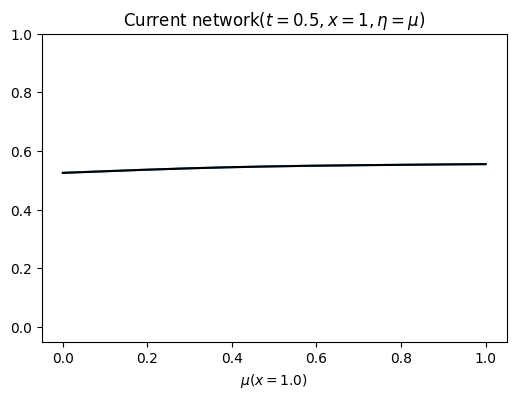

Avg loss for epoch 1 was: 0.19861438870429993
Avg loss for epoch 2 was: 0.06375792622566223
Avg loss for epoch 3 was: 0.011571677401661873
Avg loss for epoch 4 was: 0.0015862863510847092
Avg loss for epoch 5 was: 0.001168226939626038
The network being trained results in:


<Figure size 640x480 with 0 Axes>

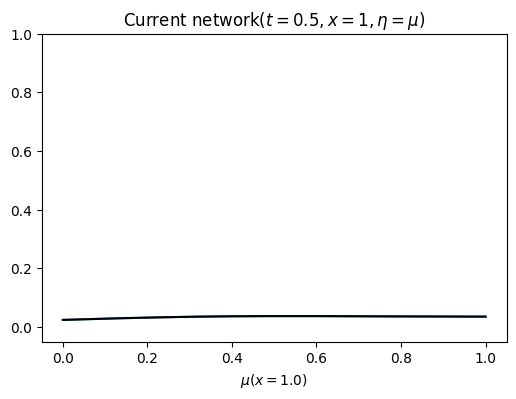

Avg loss for epoch 6 was: 0.00105826067738235
Avg loss for epoch 7 was: 0.000993903260678053
Avg loss for epoch 8 was: 0.0009288220899179578
Avg loss for epoch 9 was: 0.0008876853389665484
Avg loss for epoch 10 was: 0.0008444039267487824
The network being trained results in:


<Figure size 640x480 with 0 Axes>

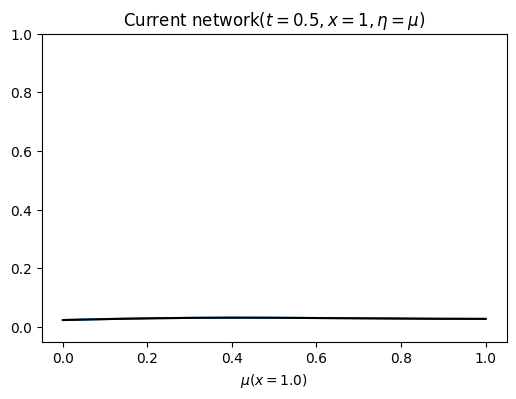

Avg loss for epoch 11 was: 0.0008031902834773064
Avg loss for epoch 12 was: 0.000753756845369935
Avg loss for epoch 13 was: 0.0007115548942238092
Avg loss for epoch 14 was: 0.0006725202547386289
Avg loss for epoch 15 was: 0.0006394204101525247
The network being trained results in:


<Figure size 640x480 with 0 Axes>

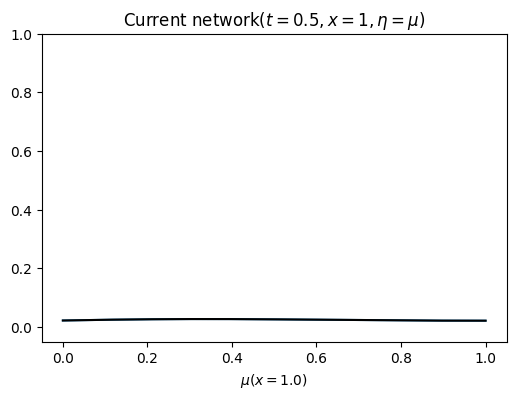

Avg loss for epoch 16 was: 0.0006062306347303092
Avg loss for epoch 17 was: 0.0005687617813237011
Avg loss for epoch 18 was: 0.0005452270852401853
Avg loss for epoch 19 was: 0.0005180534208193421
Avg loss for epoch 20 was: 0.0004913702723570168
The network being trained results in:


<Figure size 640x480 with 0 Axes>

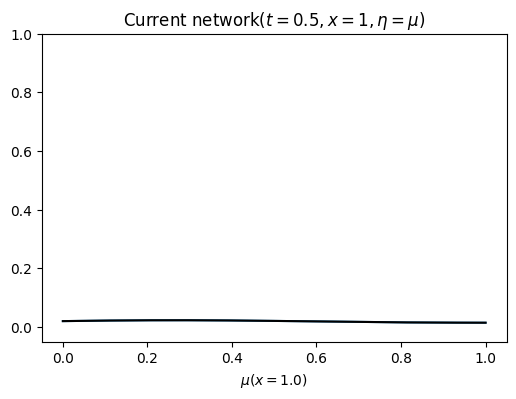

Avg loss for epoch 21 was: 0.0004660765698645264
Avg loss for epoch 22 was: 0.000446175952674821
Avg loss for epoch 23 was: 0.0004220127302687615
Avg loss for epoch 24 was: 0.0003959888417739421
Avg loss for epoch 25 was: 0.000372995447833091
The network being trained results in:


<Figure size 640x480 with 0 Axes>

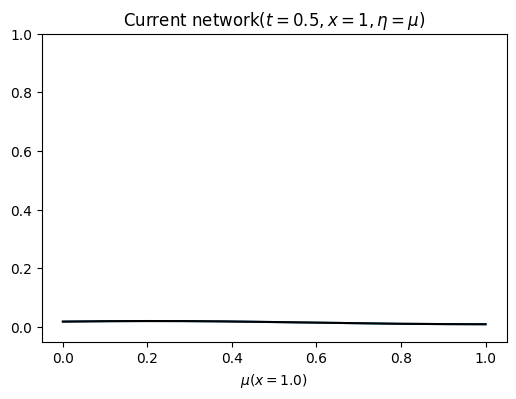

Avg loss for epoch 26 was: 0.00035584851866587996
Avg loss for epoch 27 was: 0.0003338994283694774
Avg loss for epoch 28 was: 0.00031788457999937236
Avg loss for epoch 29 was: 0.0002979831479024142
Avg loss for epoch 30 was: 0.0002817987697198987
The network being trained results in:


<Figure size 640x480 with 0 Axes>

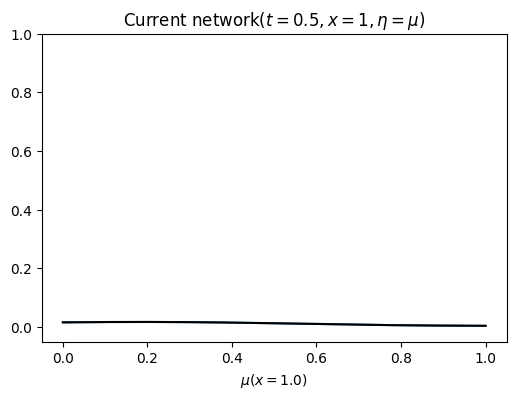

Avg loss for epoch 31 was: 0.0002648317313287407
Avg loss for epoch 32 was: 0.00025233448832295835
Avg loss for epoch 33 was: 0.0002488387399353087
Avg loss for epoch 34 was: 0.00023908809816930443
Avg loss for epoch 35 was: 0.0002354616590309888
The network being trained results in:


<Figure size 640x480 with 0 Axes>

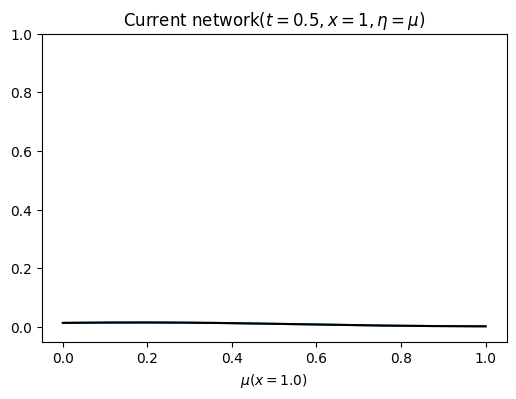

Avg loss for epoch 36 was: 0.00024097335699480027
Avg loss for epoch 37 was: 0.00022978219203650951
Avg loss for epoch 38 was: 0.00022753032681066543
Avg loss for epoch 39 was: 0.0002218379668192938
Avg loss for epoch 40 was: 0.0002170683437725529
The network being trained results in:


<Figure size 640x480 with 0 Axes>

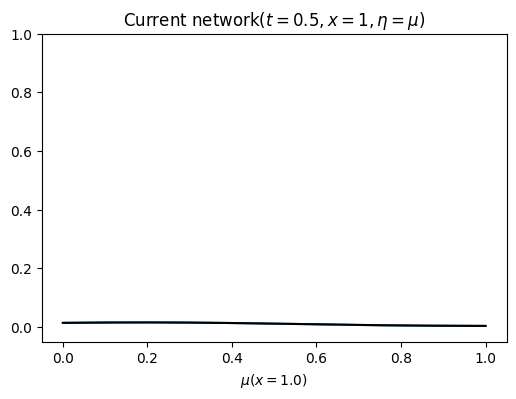

Avg loss for epoch 41 was: 0.00021201690833549947
Avg loss for epoch 42 was: 0.0002066751621896401
Avg loss for epoch 43 was: 0.0002088784531224519
Avg loss for epoch 44 was: 0.0002022055850829929
Avg loss for epoch 45 was: 0.00019550281285773963
The network being trained results in:


<Figure size 640x480 with 0 Axes>

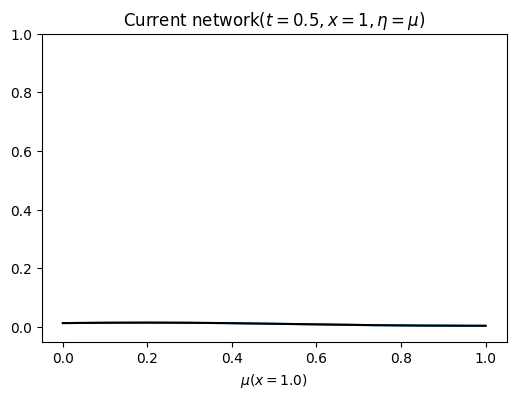

Avg loss for epoch 46 was: 0.00018934605759568512
Avg loss for epoch 47 was: 0.00018634001025930047
Avg loss for epoch 48 was: 0.00018687639385461807
Avg loss for epoch 49 was: 0.00018186672241427004
Avg loss for epoch 50 was: 0.00017336796736344695
The network being trained results in:


<Figure size 640x480 with 0 Axes>

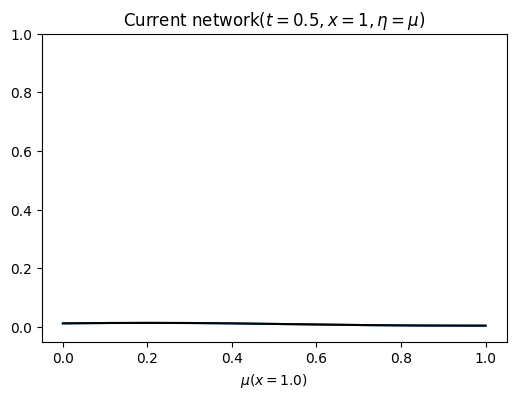

Avg loss for epoch 51 was: 0.00017265361384488642
Avg loss for epoch 52 was: 0.000168332684552297
Avg loss for epoch 53 was: 0.0001659343106439337
Avg loss for epoch 54 was: 0.00015871159848757088
Avg loss for epoch 55 was: 0.00015704594261478633
The network being trained results in:


<Figure size 640x480 with 0 Axes>

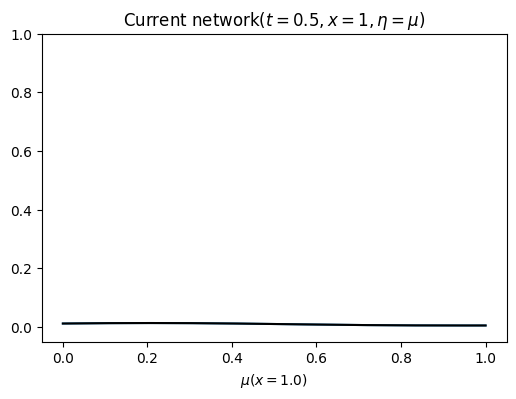

Avg loss for epoch 56 was: 0.0001525776751805097
Avg loss for epoch 57 was: 0.00015033825184218585
Avg loss for epoch 58 was: 0.00014899132656864822
Avg loss for epoch 59 was: 0.00014447949070017785
Avg loss for epoch 60 was: 0.0001410413533449173
The network being trained results in:


<Figure size 640x480 with 0 Axes>

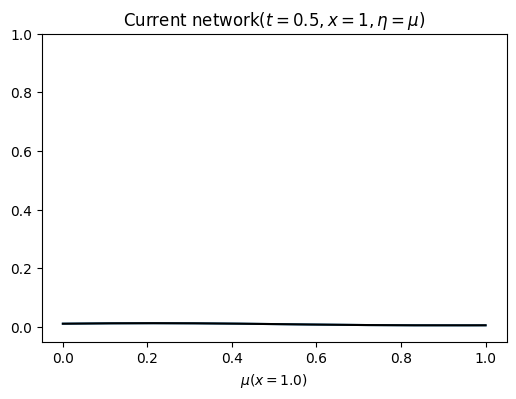

Avg loss for epoch 61 was: 0.00013533135643228889
Avg loss for epoch 62 was: 0.0001342917385045439
Avg loss for epoch 63 was: 0.00012675295874942094
Avg loss for epoch 64 was: 0.00012391337077133358
Avg loss for epoch 65 was: 0.00012233338202349842
The network being trained results in:


<Figure size 640x480 with 0 Axes>

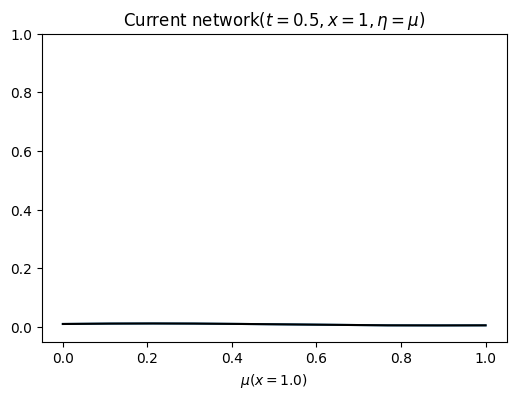

Avg loss for epoch 66 was: 0.00011784253001678735
Avg loss for epoch 67 was: 0.00011908207670785487
Avg loss for epoch 68 was: 0.00011278897000011057
Avg loss for epoch 69 was: 0.00011528626055223867
Avg loss for epoch 70 was: 0.00010914271115325391
The network being trained results in:


<Figure size 640x480 with 0 Axes>

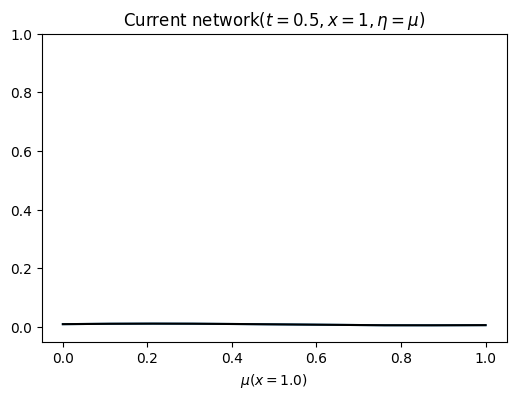

Avg loss for epoch 71 was: 0.0001038177142618224
Avg loss for epoch 72 was: 0.00010420109174447134
Avg loss for epoch 73 was: 9.969226812245324e-05
Avg loss for epoch 74 was: 9.595469600753859e-05
Avg loss for epoch 75 was: 9.72612397163175e-05
The network being trained results in:


<Figure size 640x480 with 0 Axes>

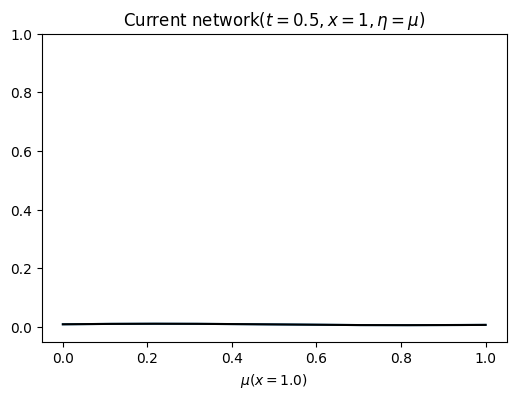

Avg loss for epoch 76 was: 9.307925211032853e-05
Avg loss for epoch 77 was: 8.698692545294762e-05
Avg loss for epoch 78 was: 8.567278564441949e-05
Avg loss for epoch 79 was: 8.246946526924148e-05
Avg loss for epoch 80 was: 7.951236329972744e-05
The network being trained results in:


<Figure size 640x480 with 0 Axes>

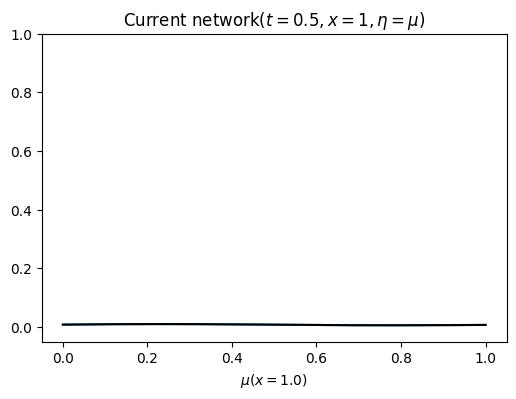

Avg loss for epoch 81 was: 7.849040412111208e-05
Avg loss for epoch 82 was: 7.379326416412368e-05
Avg loss for epoch 83 was: 7.315901893889531e-05
Avg loss for epoch 84 was: 7.086932600941509e-05
Avg loss for epoch 85 was: 6.736923387506977e-05
The network being trained results in:


<Figure size 640x480 with 0 Axes>

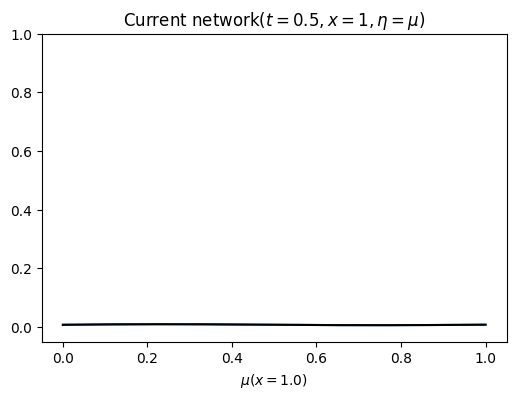

Avg loss for epoch 86 was: 6.621883221669123e-05
Avg loss for epoch 87 was: 6.231439328985289e-05
Avg loss for epoch 88 was: 6.0855843912577257e-05
Avg loss for epoch 89 was: 5.887993756914511e-05
Avg loss for epoch 90 was: 5.704569775843993e-05
The network being trained results in:


<Figure size 640x480 with 0 Axes>

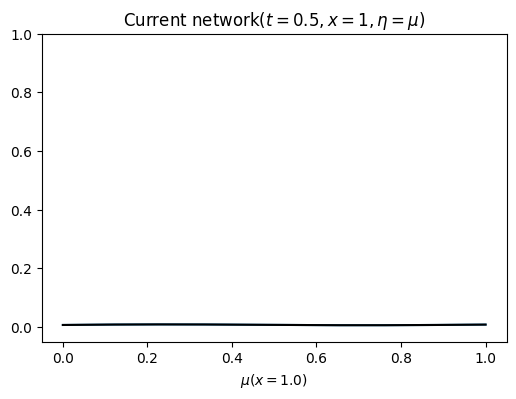

Avg loss for epoch 91 was: 5.487506132340059e-05
Avg loss for epoch 92 was: 5.266840526019223e-05
Avg loss for epoch 93 was: 5.117145337862894e-05
Avg loss for epoch 94 was: 4.881073618889786e-05
Avg loss for epoch 95 was: 4.714496753877029e-05
The network being trained results in:


<Figure size 640x480 with 0 Axes>

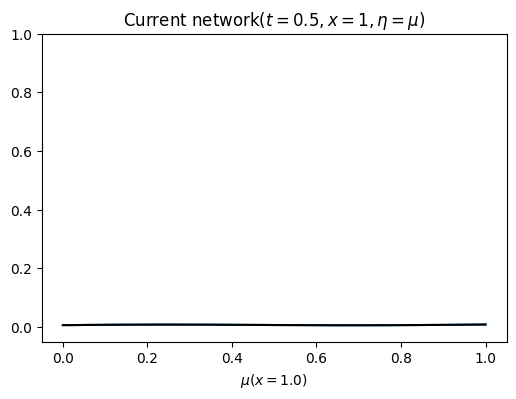

Avg loss for epoch 96 was: 4.4556658394867554e-05
Avg loss for epoch 97 was: 4.3532596464501694e-05
Avg loss for epoch 98 was: 4.113706017960794e-05
Avg loss for epoch 99 was: 3.955709689762443e-05
Avg loss for epoch 100 was: 3.8324607885442674e-05
The network being trained results in:


<Figure size 640x480 with 0 Axes>

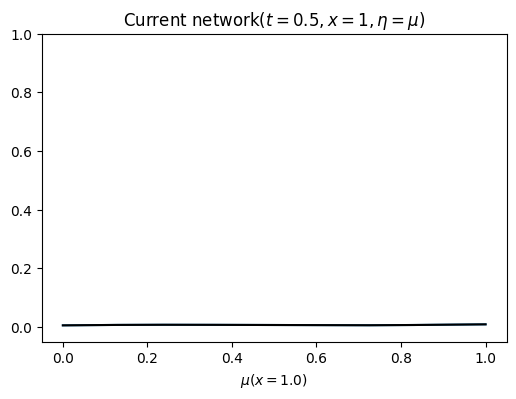

Avg loss for epoch 101 was: 3.629341154010035e-05
Avg loss for epoch 102 was: 3.4454020351404324e-05
Avg loss for epoch 103 was: 3.279205702710897e-05
Avg loss for epoch 104 was: 3.185671448591165e-05
Avg loss for epoch 105 was: 2.9215678296168335e-05
The network being trained results in:


<Figure size 640x480 with 0 Axes>

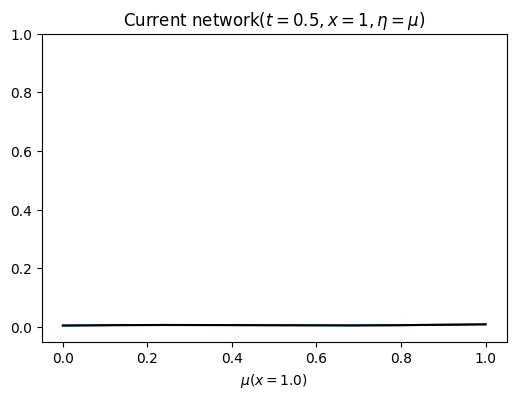

Avg loss for epoch 106 was: 2.867899638658855e-05
Avg loss for epoch 107 was: 2.678281998669263e-05
Avg loss for epoch 108 was: 2.4140867026289925e-05
Avg loss for epoch 109 was: 2.3459986550733447e-05
Avg loss for epoch 110 was: 2.264895010739565e-05
The network being trained results in:


<Figure size 640x480 with 0 Axes>

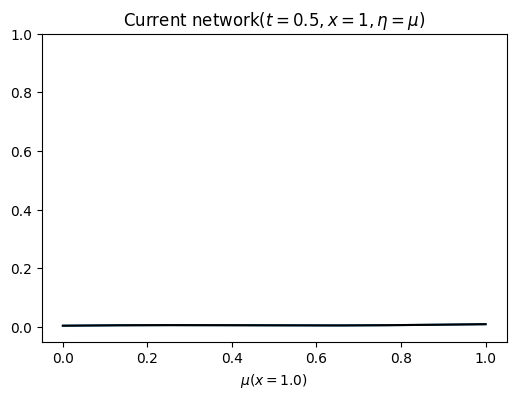

Avg loss for epoch 111 was: 2.1749659936176613e-05
Avg loss for epoch 112 was: 2.0821527868974954e-05
Avg loss for epoch 113 was: 2.001419306907337e-05
Avg loss for epoch 114 was: 1.8854227164410986e-05
Avg loss for epoch 115 was: 1.7863658285932615e-05
The network being trained results in:


<Figure size 640x480 with 0 Axes>

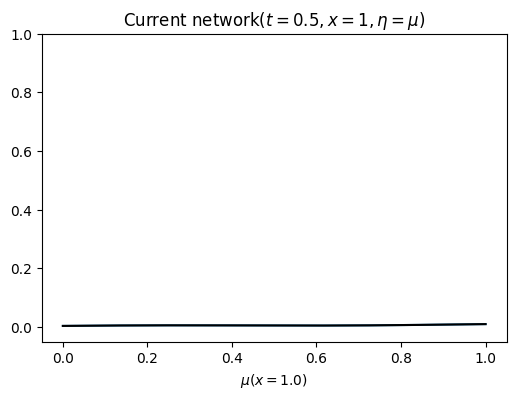

Avg loss for epoch 116 was: 1.60041126946453e-05
Avg loss for epoch 117 was: 1.5541945685981773e-05
Avg loss for epoch 118 was: 1.5265228284988552e-05
Avg loss for epoch 119 was: 1.387553675158415e-05
Avg loss for epoch 120 was: 1.2936822713527363e-05
The network being trained results in:


<Figure size 640x480 with 0 Axes>

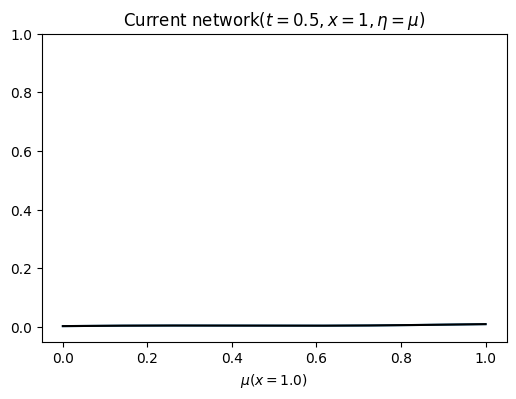

Avg loss for epoch 121 was: 1.2171138223493472e-05
Avg loss for epoch 122 was: 1.0786485290736891e-05
Avg loss for epoch 123 was: 9.800557563721668e-06
Avg loss for epoch 124 was: 9.556624718243256e-06
Avg loss for epoch 125 was: 8.868581062415615e-06
The network being trained results in:


<Figure size 640x480 with 0 Axes>

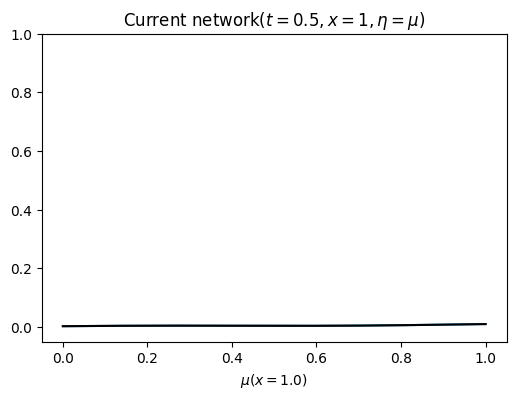

Avg loss for epoch 126 was: 9.290757589042187e-06
Avg loss for epoch 127 was: 8.857511602400336e-06
Avg loss for epoch 128 was: 8.384302418562584e-06
Avg loss for epoch 129 was: 7.778366125421599e-06
Avg loss for epoch 130 was: 7.504189852625132e-06
The network being trained results in:


<Figure size 640x480 with 0 Axes>

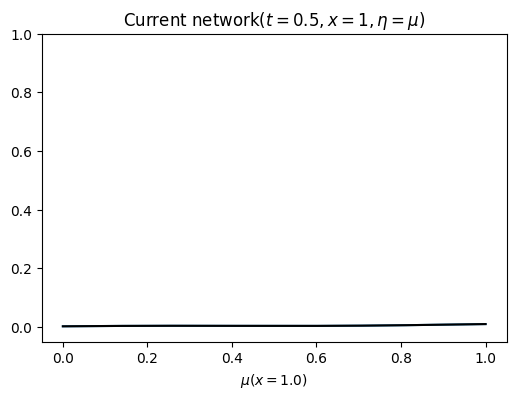

Avg loss for epoch 131 was: 6.905150257807691e-06
Avg loss for epoch 132 was: 6.678104455204448e-06
Avg loss for epoch 133 was: 6.424640105251456e-06
Avg loss for epoch 134 was: 6.4141586335608736e-06
Avg loss for epoch 135 was: 5.527143457584316e-06
The network being trained results in:


<Figure size 640x480 with 0 Axes>

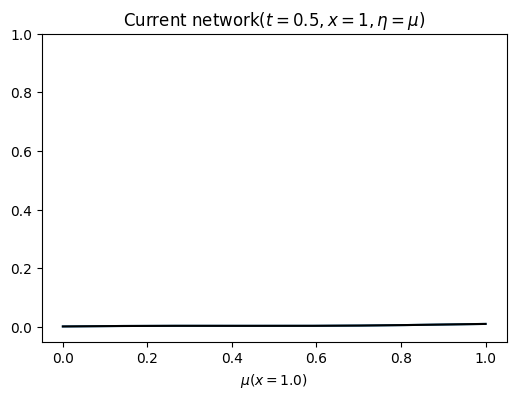

Avg loss for epoch 136 was: 4.9264795052295085e-06
Avg loss for epoch 137 was: 5.10117888552486e-06
Avg loss for epoch 138 was: 4.987427928426769e-06
Avg loss for epoch 139 was: 4.785566034115618e-06
Avg loss for epoch 140 was: 4.001866273029009e-06
The network being trained results in:


<Figure size 640x480 with 0 Axes>

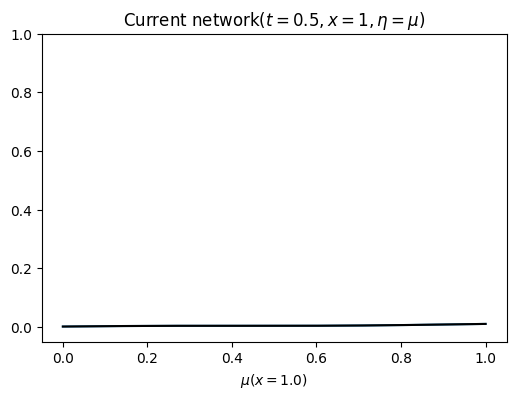

Avg loss for epoch 141 was: 4.222492407279788e-06
Avg loss for epoch 142 was: 4.552083737507928e-06
Avg loss for epoch 143 was: 4.446190359885804e-06
Avg loss for epoch 144 was: 4.2699957703007385e-06
Avg loss for epoch 145 was: 3.7965473893564194e-06
The network being trained results in:


<Figure size 640x480 with 0 Axes>

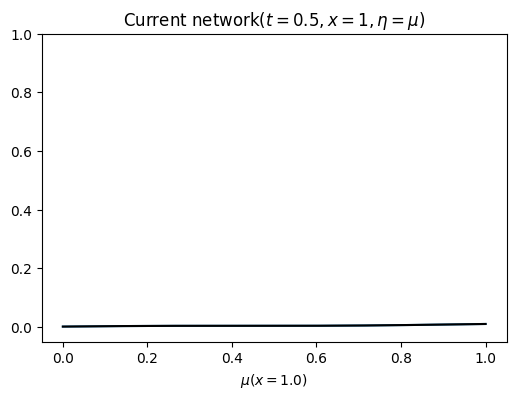

Avg loss for epoch 146 was: 3.6999738313170383e-06
Avg loss for epoch 147 was: 3.925898454326671e-06
Avg loss for epoch 148 was: 3.85142220693524e-06
Avg loss for epoch 149 was: 3.8950897760514636e-06

----------training network 49----------
Avg loss for epoch 0 was: 0.00013027306704316288
The network being trained results in:


<Figure size 640x480 with 0 Axes>

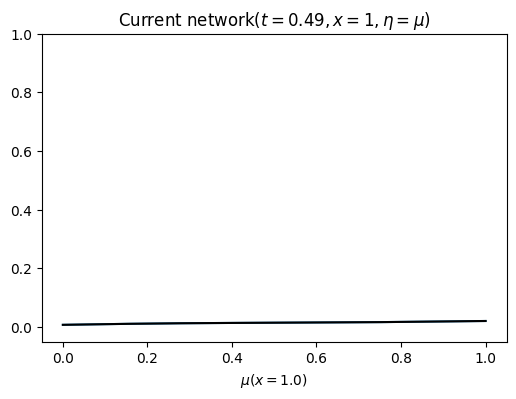

Avg loss for epoch 1 was: 5.465670255944133e-05
Avg loss for epoch 2 was: 4.616258229361847e-05
Avg loss for epoch 3 was: 3.970256875618361e-05
Avg loss for epoch 4 was: 3.441874650889076e-05
Avg loss for epoch 5 was: 3.227314664400183e-05
The network being trained results in:


<Figure size 640x480 with 0 Axes>

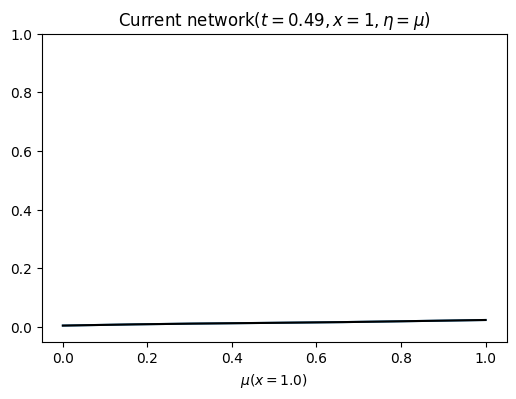

Avg loss for epoch 6 was: 3.082594048464671e-05
Avg loss for epoch 7 was: 2.7320147637510672e-05
Avg loss for epoch 8 was: 2.5155859475489706e-05
Avg loss for epoch 9 was: 1.9842496840283275e-05
Avg loss for epoch 10 was: 1.7397494957549497e-05
The network being trained results in:


<Figure size 640x480 with 0 Axes>

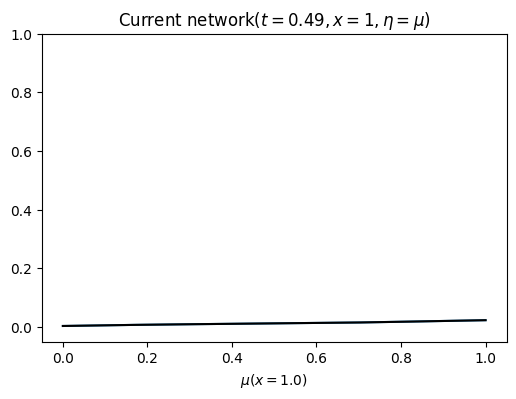

Avg loss for epoch 11 was: 1.4740275219082832e-05
Avg loss for epoch 12 was: 1.3802418834529817e-05
Avg loss for epoch 13 was: 1.3038209544902202e-05
Avg loss for epoch 14 was: 1.2750356290780474e-05
Avg loss for epoch 15 was: 1.2061605957569554e-05
The network being trained results in:


<Figure size 640x480 with 0 Axes>

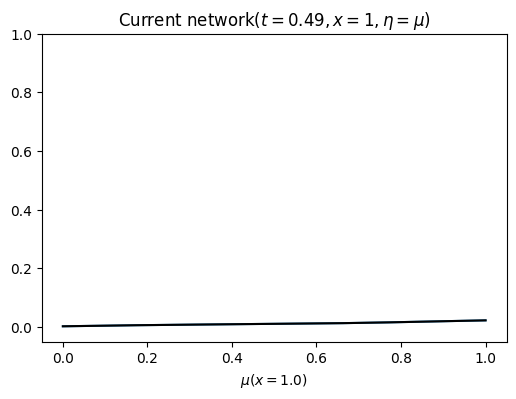

Avg loss for epoch 16 was: 1.1417333553254139e-05
Avg loss for epoch 17 was: 8.30753197078593e-06
Avg loss for epoch 18 was: 6.690339887427399e-06
Avg loss for epoch 19 was: 6.742144705640385e-06
Avg loss for epoch 20 was: 5.607848834188189e-06
The network being trained results in:


<Figure size 640x480 with 0 Axes>

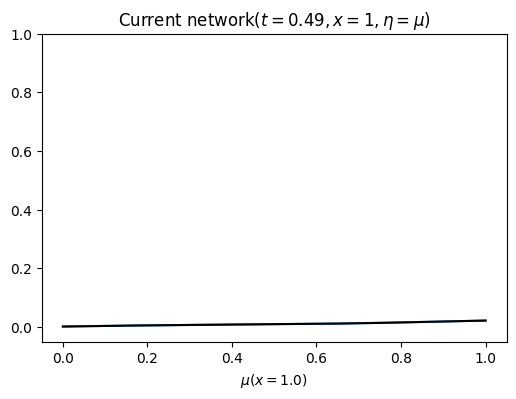

Avg loss for epoch 21 was: 4.984977749700192e-06
Avg loss for epoch 22 was: 4.497569534578361e-06
Avg loss for epoch 23 was: 4.160815933573758e-06
Avg loss for epoch 24 was: 4.139682005188661e-06
Avg loss for epoch 25 was: 3.759879746212391e-06
The network being trained results in:


<Figure size 640x480 with 0 Axes>

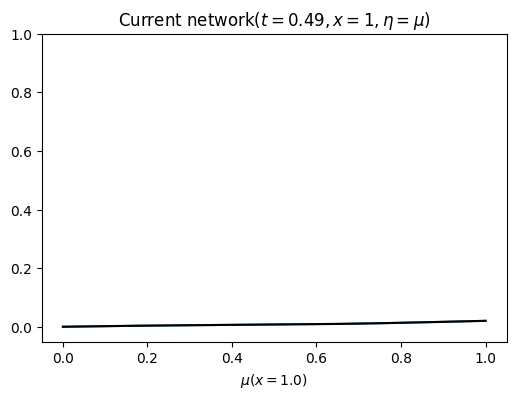

Avg loss for epoch 26 was: 3.2299076337949373e-06
Avg loss for epoch 27 was: 3.788061349041527e-06
Avg loss for epoch 28 was: 3.622117674240144e-06
Avg loss for epoch 29 was: 3.340237299198634e-06
Avg loss for epoch 30 was: 3.2526399991184007e-06
The network being trained results in:


<Figure size 640x480 with 0 Axes>

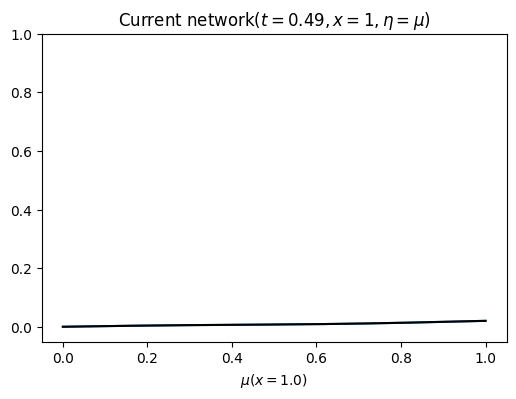

Avg loss for epoch 31 was: 2.963450697279768e-06
Avg loss for epoch 32 was: 2.662764472916024e-06
Avg loss for epoch 33 was: 2.3811369374016067e-06
Avg loss for epoch 34 was: 1.8277114577358589e-06
Avg loss for epoch 35 was: 1.8003554487222573e-06
The network being trained results in:


<Figure size 640x480 with 0 Axes>

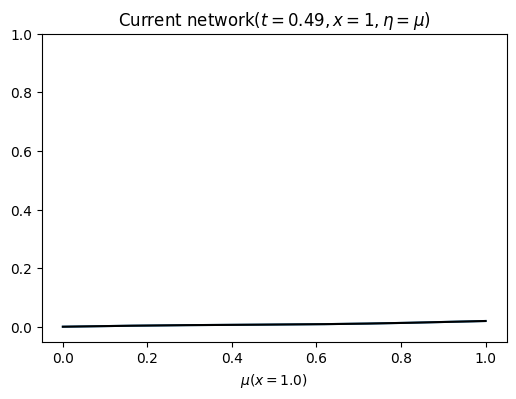

Avg loss for epoch 36 was: 2.1539119643421145e-06
Avg loss for epoch 37 was: 2.3349878119915957e-06
Avg loss for epoch 38 was: 2.209601461800048e-06
Avg loss for epoch 39 was: 1.9352751223777886e-06
Avg loss for epoch 40 was: 2.1963774088362698e-06
The network being trained results in:


<Figure size 640x480 with 0 Axes>

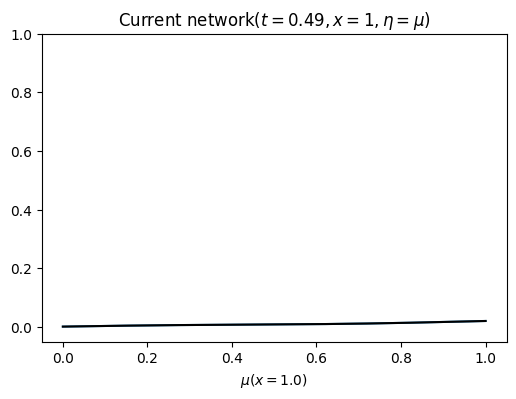

Avg loss for epoch 41 was: 2.0744519133586437e-06
Avg loss for epoch 42 was: 2.115302550009801e-06
Avg loss for epoch 43 was: 2.1808921246702084e-06
Avg loss for epoch 44 was: 2.1332050437194994e-06
Avg loss for epoch 45 was: 1.3839977555107907e-06
The network being trained results in:


<Figure size 640x480 with 0 Axes>

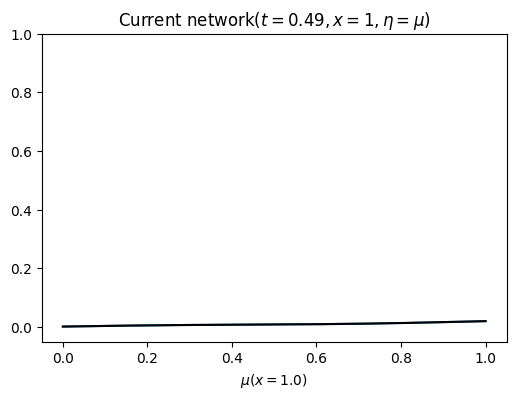

Avg loss for epoch 46 was: 1.1024869763787137e-06
Avg loss for epoch 47 was: 1.1444228675827617e-06
Avg loss for epoch 48 was: 1.284335439777351e-06
Avg loss for epoch 49 was: 1.2790463870260282e-06

----------training network 48----------
Avg loss for epoch 0 was: 0.00014189304783940315
The network being trained results in:


<Figure size 640x480 with 0 Axes>

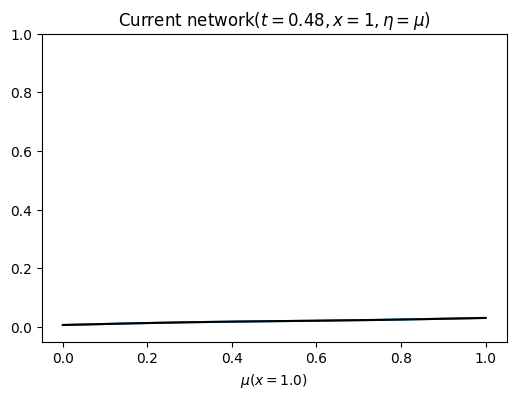

Avg loss for epoch 1 was: 6.248473073355854e-05
Avg loss for epoch 2 was: 4.43838544015307e-05
Avg loss for epoch 3 was: 3.852434383588843e-05
Avg loss for epoch 4 was: 3.291637767688371e-05
Avg loss for epoch 5 was: 2.8931446649949066e-05
The network being trained results in:


<Figure size 640x480 with 0 Axes>

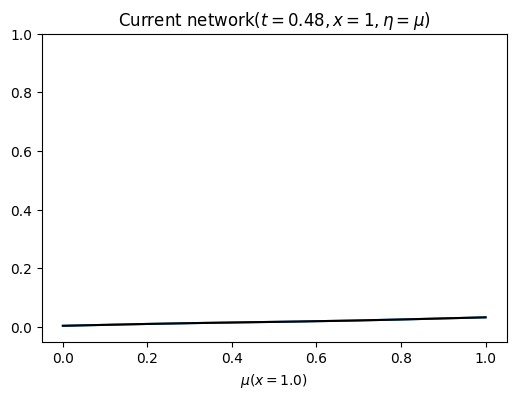

Avg loss for epoch 6 was: 2.3741713448544033e-05
Avg loss for epoch 7 was: 2.1091931557748467e-05
Avg loss for epoch 8 was: 1.9052105926675722e-05
Avg loss for epoch 9 was: 1.5961566532496363e-05
Avg loss for epoch 10 was: 1.3841135114489589e-05
The network being trained results in:


<Figure size 640x480 with 0 Axes>

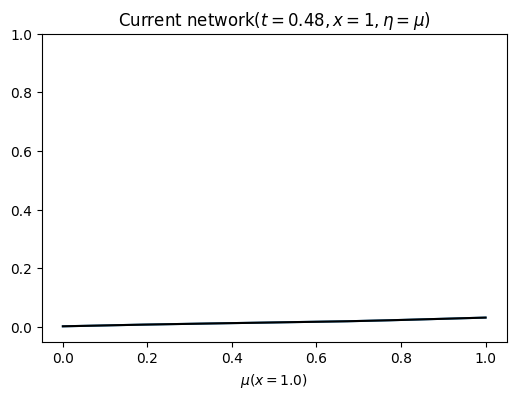

Avg loss for epoch 11 was: 1.227099619427463e-05
Avg loss for epoch 12 was: 1.2086426067980938e-05
Avg loss for epoch 13 was: 1.2853386579081416e-05
Avg loss for epoch 14 was: 1.0219688192592002e-05
Avg loss for epoch 15 was: 9.594575203664135e-06
The network being trained results in:


<Figure size 640x480 with 0 Axes>

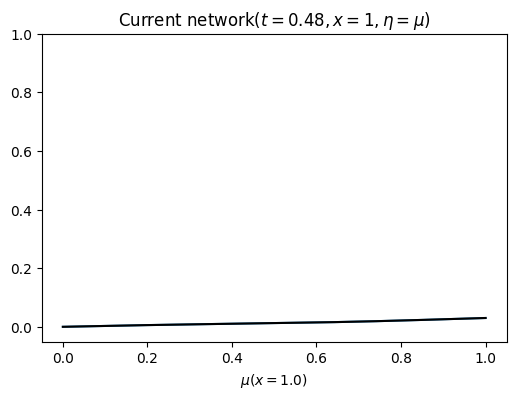

Avg loss for epoch 16 was: 8.746083949517924e-06
Avg loss for epoch 17 was: 6.908032446517609e-06
Avg loss for epoch 18 was: 6.7237579060019925e-06
Avg loss for epoch 19 was: 5.5953273658815306e-06
Avg loss for epoch 20 was: 5.083625637780642e-06
The network being trained results in:


<Figure size 640x480 with 0 Axes>

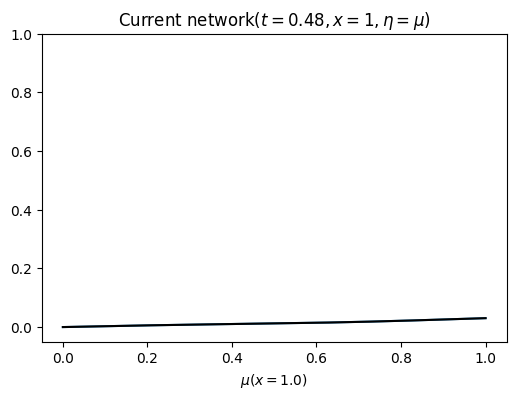

Avg loss for epoch 21 was: 4.6338550419022795e-06
Avg loss for epoch 22 was: 4.571976205625106e-06
Avg loss for epoch 23 was: 4.436011749930913e-06
Avg loss for epoch 24 was: 3.891222604579525e-06
Avg loss for epoch 25 was: 3.735411610250594e-06
The network being trained results in:


<Figure size 640x480 with 0 Axes>

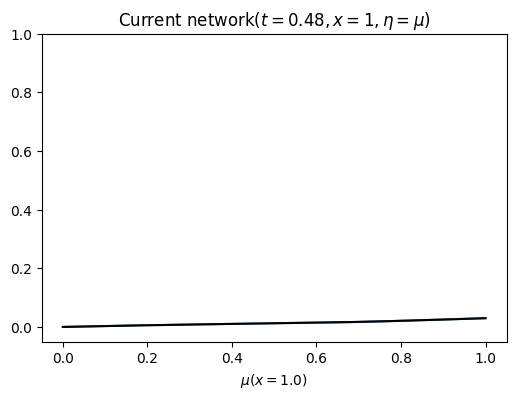

Avg loss for epoch 26 was: 3.744476089195814e-06
Avg loss for epoch 27 was: 3.3891762996063335e-06
Avg loss for epoch 28 was: 3.0247849736042554e-06
Avg loss for epoch 29 was: 3.3305780107184546e-06
Avg loss for epoch 30 was: 3.228874902561074e-06
The network being trained results in:


<Figure size 640x480 with 0 Axes>

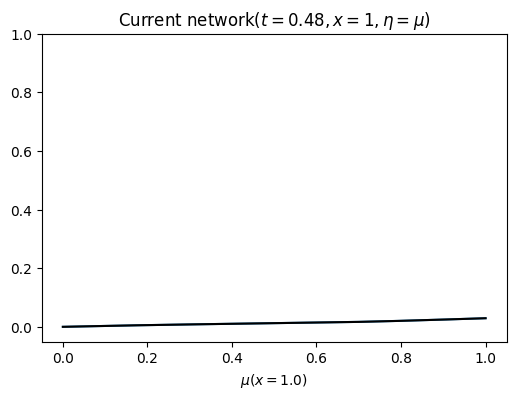

Avg loss for epoch 31 was: 3.2550904052186524e-06
Avg loss for epoch 32 was: 2.793947487589321e-06
Avg loss for epoch 33 was: 3.1282813779398566e-06
Avg loss for epoch 34 was: 2.87881607619056e-06
Avg loss for epoch 35 was: 2.1258410924929194e-06
The network being trained results in:


<Figure size 640x480 with 0 Axes>

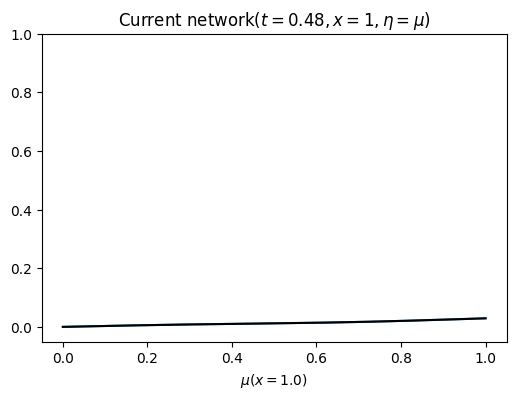

Avg loss for epoch 36 was: 1.989811380553874e-06
Avg loss for epoch 37 was: 2.260066366943647e-06
Avg loss for epoch 38 was: 2.5983388241002103e-06
Avg loss for epoch 39 was: 2.555551645855303e-06
Avg loss for epoch 40 was: 2.3245452211995143e-06
The network being trained results in:


<Figure size 640x480 with 0 Axes>

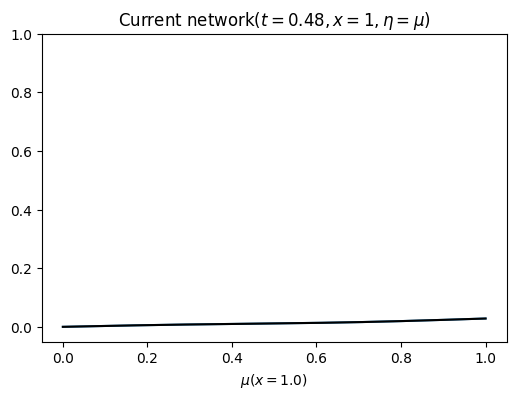

Avg loss for epoch 41 was: 2.136957391485339e-06
Avg loss for epoch 42 was: 1.999224650717224e-06
Avg loss for epoch 43 was: 2.0036725345562445e-06
Avg loss for epoch 44 was: 1.8798526753016631e-06
Avg loss for epoch 45 was: 1.8910349126599613e-06
The network being trained results in:


<Figure size 640x480 with 0 Axes>

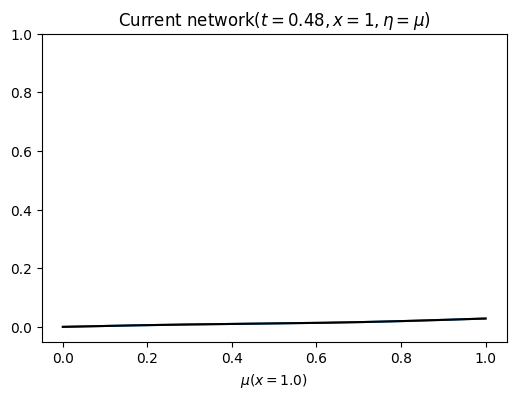

Avg loss for epoch 46 was: 1.7098329863074468e-06
Avg loss for epoch 47 was: 1.6796273030195152e-06
Avg loss for epoch 48 was: 1.7214390481967712e-06
Avg loss for epoch 49 was: 1.929934569488978e-06

----------training network 47----------
Avg loss for epoch 0 was: 0.00010358285362599418
The network being trained results in:


<Figure size 640x480 with 0 Axes>

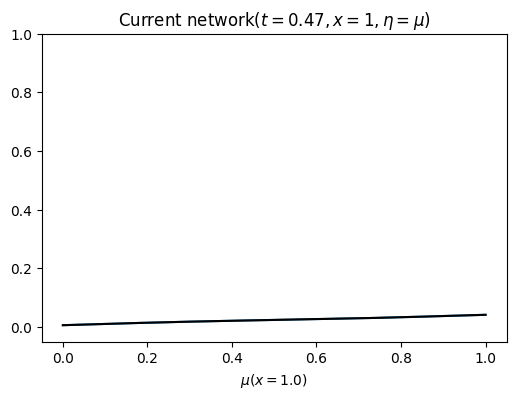

Avg loss for epoch 1 was: 4.241713395458646e-05
Avg loss for epoch 2 was: 3.380128327989951e-05
Avg loss for epoch 3 was: 3.120620021945797e-05
Avg loss for epoch 4 was: 2.5050163458217867e-05
Avg loss for epoch 5 was: 2.4191862394218333e-05
The network being trained results in:


<Figure size 640x480 with 0 Axes>

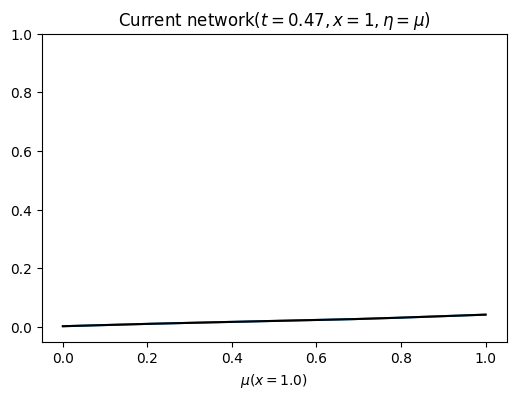

Avg loss for epoch 6 was: 1.9163886463502422e-05
Avg loss for epoch 7 was: 1.7056505384971388e-05
Avg loss for epoch 8 was: 1.4912699043634348e-05
Avg loss for epoch 9 was: 1.2502745448728092e-05
Avg loss for epoch 10 was: 9.620425771572627e-06
The network being trained results in:


<Figure size 640x480 with 0 Axes>

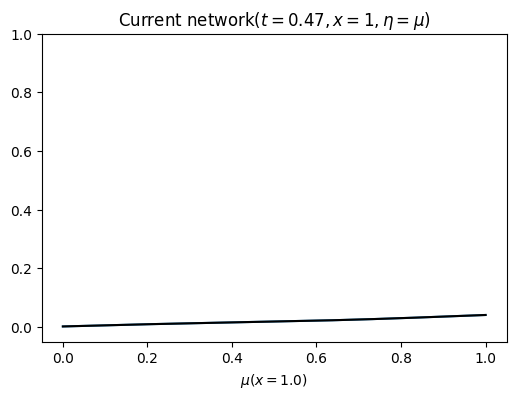

Avg loss for epoch 11 was: 9.567029337631539e-06
Avg loss for epoch 12 was: 8.38870710140327e-06
Avg loss for epoch 13 was: 7.116099368431605e-06
Avg loss for epoch 14 was: 6.148105967440642e-06
Avg loss for epoch 15 was: 6.669351478194585e-06
The network being trained results in:


<Figure size 640x480 with 0 Axes>

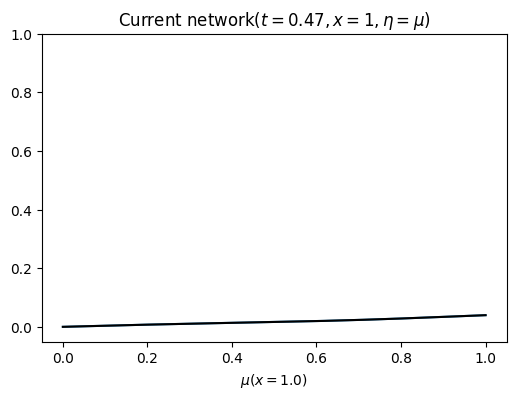

Avg loss for epoch 16 was: 4.7496246224909555e-06
Avg loss for epoch 17 was: 3.839810233330354e-06
Avg loss for epoch 18 was: 3.6304329569247784e-06
Avg loss for epoch 19 was: 3.989765900769271e-06
Avg loss for epoch 20 was: 3.3426290428906213e-06
The network being trained results in:


<Figure size 640x480 with 0 Axes>

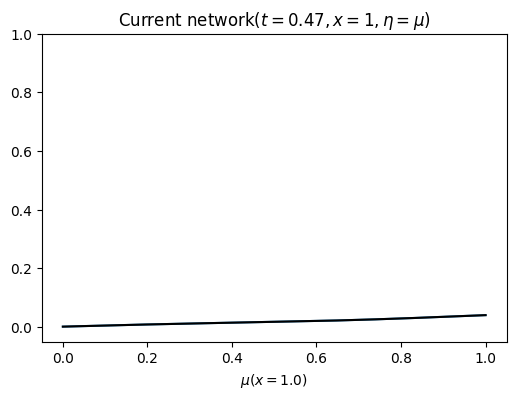

Avg loss for epoch 21 was: 3.3619432997511467e-06
Avg loss for epoch 22 was: 4.554282440949464e-06
Avg loss for epoch 23 was: 3.965121777582681e-06


In [ ]:
trainer = Train(model_architecture = [d+1,60,60,60,60], dataset_generator = DBDatasetGenerator(), partition_step = 0.01, oversampling = True, verbose = True, visual_output=True)
mesh = trainer.train(epochs = 50, steps_per_epoch = 30, learning_rate = 1e-4)